In [1]:
import os
import numpy as np
from keras.preprocessing import text, sequence

# Read text samples from IMDB dataset.

def load_data_from_imdb(sample_dir, max_length=100, max_words=10000):
    '''
    Read movie review samples and labels from IMDB dataset.
    Samples and labels are tokenized by using keras preprocessing utility.
    '''
    labels = []
    texts = []

    # IMDB dataset directory has 'neg' directory which has negative review samples,
    # and 'pos' otherwise.
    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(sample_dir, label_type)
        for file_name in os.listdir(dir_name):
            if file_name[-4:] == '.txt':
                file = open(os.path.join(dir_name, file_name), encoding='utf8')
                texts.append(file.read())
                file.close()
                # Labeling, negative review has label 0, positive has 1.
                if label_type == 'neg':
                    labels.append(0)
                else:
                    labels.append(1)

    # Tokenize text samples to the input vectors.
    # Choose most frequently used words in dataset.
    tokenizer = text.Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    # Convert words in samples to corresponding indices.
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    
    # Slice words in a sample as max_length.
    data = sequence.pad_sequences(sequences, maxlen=max_length)
    labels = np.asarray(labels)
    
    return data, labels, word_index

Using TensorFlow backend.


In [2]:
def load_embedding_index_from_glove(glove_data_file, embedding_dim, word_index, max_words):
    '''
    Return a embedding weight matrix from the GloVe model.
    'glove.6B' has word embedding which was trained with english wikipia posts.
    It has 50, 100, 200 and 300 dimension embedding vectors coressponding to 400k words(or tokens).
    '''
    embeddings_index = {}

    file = open(glove_data_file, encoding='utf8')
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    file.close()
    
    
    # Make embedding weight matrix.
    # Entries which has a word not in embedding word index are zero.
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [3]:
dataset_dir = '/home/guhwanbae/workspace/machine-learning/resource'
imdb_dir = os.path.join(dataset_dir, 'aclImdb')
train_dir = os.path.join(imdb_dir, 'train')

max_length = 100
max_words = 10000
data, labels, word_index = load_data_from_imdb(sample_dir=train_dir,
                                               max_length=max_length,
                                               max_words=max_words)

print('Shape of data =', data.shape)
print('Shape of lables =', labels.shape)
print('Word index has %d entries.' % len(word_index))

Shape of data = (25000, 100)
Shape of lables = (25000,)
Word index has 88582 entries.


In [4]:
glove_dir = os.path.join(dataset_dir, 'glove.6B')
glove_data_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

embedding_dim = 100
embedding_matrix = load_embedding_index_from_glove(glove_data_file,
                                                   embedding_dim,
                                                   word_index,
                                                   max_words)

In [5]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

# Load GloVe embedding vectors to this model.
# And freeze first layer, embedding layer.
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

# Shuffle data and labels entries.
data = data[indices]
labels = labels[indices]

'''
Suppose we have small training data.
In this case, effective strategy is using features of the pre-trained model.
'''

training_samples = 400
validation_samples = 10000

train_data = data[:training_samples]
train_labels = labels[:training_samples]
validation_data = data[training_samples:training_samples+validation_samples]
validation_labels = labels[training_samples:training_samples+validation_samples]

print('Shape of train data =', train_data.shape)
print('Shape of validation data =', validation_data.shape)

Shape of train data = (400, 100)
Shape of validation data = (10000, 100)


In [7]:
history = model.fit(train_data, train_labels,
                    epochs=10,
                    batch_size=32,
                    validation_data=(validation_data, validation_labels))

Train on 400 samples, validate on 10000 samples
Epoch 1/10
400/400 [==============================] - 0s 1ms/step - loss: 1.3867 - acc: 0.5100 - val_loss: 0.8120 - val_acc: 0.4996
Epoch 2/10
400/400 [==============================] - 0s 622us/step - loss: 0.5703 - acc: 0.6550 - val_loss: 0.7091 - val_acc: 0.5401
Epoch 3/10
400/400 [==============================] - 0s 603us/step - loss: 0.4922 - acc: 0.7500 - val_loss: 1.0586 - val_acc: 0.5024
Epoch 4/10
400/400 [==============================] - 0s 642us/step - loss: 0.4057 - acc: 0.7750 - val_loss: 0.8261 - val_acc: 0.5345
Epoch 5/10
400/400 [==============================] - 0s 693us/step - loss: 0.3326 - acc: 0.8725 - val_loss: 0.7034 - val_acc: 0.5678
Epoch 6/10
400/400 [==============================] - 0s 719us/step - loss: 0.2438 - acc: 0.8950 - val_loss: 0.7996 - val_acc: 0.5429
Epoch 7/10
400/400 [==============================] - 0s 891us/step - loss: 0.2070 - acc: 0.9400 - val_loss: 0.9470 - val_acc: 0.5340
Epoch 8/10
400/4

In [8]:
model.save_weights('based_glove6_100d_model_with_100_train_samples.h5')

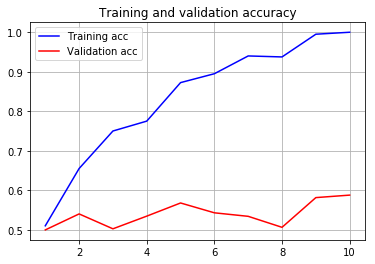

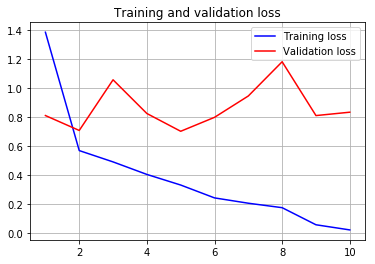

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(len(acc)) + 1

plt.figure('Training and validation accuracy')
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='b', label='Training acc')
plt.plot(epochs, val_acc, color='r', label='Validation acc')
plt.legend()
plt.grid()
plt.show()

# Model is overfitting in early iterations.
# Validation accuracy is about 50%

plt.figure('Training and validation loss')
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='b', label='Training loss')
plt.plot(epochs, val_loss, color='r', label='Validation loss')
plt.legend()
plt.grid()
plt.show()

In [105]:
# Retrain a model with 15000 train samples.

indices = np.arange(data.shape[0])
np.random.shuffle(indices)

# Shuffle data and labels entries.
data = data[indices]
labels = labels[indices]

training_samples = 15000
validation_samples = 10000

train_data = data[:training_samples]
train_labels = labels[:training_samples]
validation_data = data[training_samples:training_samples+validation_samples]
validation_labels = labels[training_samples:training_samples+validation_samples]

print('Shape of train data =', train_data.shape)
print('Shape of validation data =', validation_data.shape)

Shape of train data = (15000, 100)
Shape of validation data = (10000, 100)


In [106]:
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=max_length))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Load GloVe embedding vectors to this model.
# And freeze first layer, embedding layer.
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_15 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 32)                320032    
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 33        
Total para

In [107]:
print('The number of train data samples =', len(train_data))
print('The number of validation data samples =', len(validation_data))

history = model.fit(train_data, train_labels,
                    epochs=15,
                    batch_size=64,
                    validation_data=(validation_data, validation_labels))

The number of train data samples = 15000
The number of validation data samples = 10000
Train on 15000 samples, validate on 10000 samples
Epoch 1/15
15000/15000 [==============================] - 2s 109us/step - loss: 0.7047 - acc: 0.5020 - val_loss: 0.6932 - val_acc: 0.4953
Epoch 2/15
15000/15000 [==============================] - 1s 58us/step - loss: 0.6951 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.4958
Epoch 3/15
15000/15000 [==============================] - 1s 57us/step - loss: 0.6964 - acc: 0.5079 - val_loss: 0.6930 - val_acc: 0.4978
Epoch 4/15
15000/15000 [==============================] - 1s 63us/step - loss: 0.6935 - acc: 0.5048 - val_loss: 0.6910 - val_acc: 0.5071
Epoch 5/15
15000/15000 [==============================] - 1s 59us/step - loss: 0.6905 - acc: 0.5268 - val_loss: 0.6781 - val_acc: 0.5757
Epoch 6/15
15000/15000 [==============================] - 1s 55us/step - loss: 0.6777 - acc: 0.5653 - val_loss: 0.6674 - val_acc: 0.6087
Epoch 7/15
15000/15000 [================

In [108]:
model.save_weights('based_glove6_100d_model_with_10000_train_samples.h5')

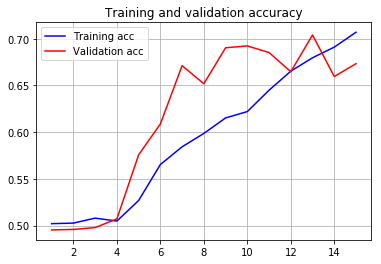

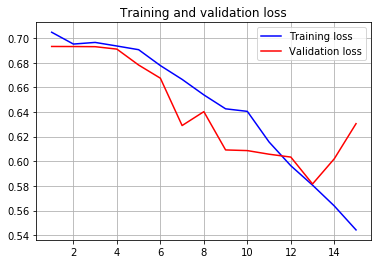

In [109]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = np.arange(len(acc)) + 1

plt.figure('Training and validation accuracy')
plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='b', label='Training acc')
plt.plot(epochs, val_acc, color='r', label='Validation acc')
plt.legend()
plt.grid()
plt.show()

# Model is overfitting after 10 iterations.
# Validation accuracy is about 70%

plt.figure('Training and validation loss')
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='b', label='Training loss')
plt.plot(epochs, val_loss, color='r', label='Validation loss')
plt.legend()
plt.grid()
plt.show()

In [110]:
# Evaluate a model with test samples.

test_dir = os.path.join(imdb_dir, 'test')

test_data, test_labels, word_index = load_data_from_imdb(test_dir, max_length=100, max_words=10000)

In [111]:
pre_trained_model = 'based_glove6_100d_model_with_10000_train_samples.h5'

model.load_weights(pre_trained_model)
loss, accuracy = model.evaluate(test_data, test_labels)

print('Model(%s) test accuracy =', accuracy)

25000/25000 [==============================] - 1s 29us/step
Model(%s) test accuracy = 0.5286
